# Model Training using MLP - 3 Features

## Load Package

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
import os

print("PyTorch version:", torch.__version__)
print("GPU Available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = "../Model/3 Features"
os.makedirs(model_dir, exist_ok=True)

PyTorch version: 2.6.0+cpu
GPU Available: False


## Load Processed Data

In [ ]:
# Specify the feature set
feature_set = "importance_gt_0.2"

# Load data
X_train = pd.read_csv(f"../Dataset/MLP Data/X_train_{feature_set}.csv").values.astype(np.float32)
X_val = pd.read_csv(f"../Dataset/MLP Data/X_val_{feature_set}.csv").values.astype(np.float32)
X_test = pd.read_csv(f"../Dataset/MLP Data/X_test_{feature_set}.csv").values.astype(np.float32)
y_train = pd.read_csv(f"../Dataset/MLP Data/y_train_{feature_set}.csv").squeeze().values.astype(np.float32)
y_val = pd.read_csv(f"../Dataset/MLP Data/y_val_{feature_set}.csv").squeeze().values.astype(np.float32)
y_test = pd.read_csv(f"../Dataset/MLP Data/y_test_{feature_set}.csv").squeeze().values.astype(np.float32)

In [3]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (80705, 3)
X_val shape: (23059, 3)
X_test shape: (11530, 3)
y_train shape: (80705,)
y_val shape: (23059,)
y_test shape: (11530,)


In [4]:
# Convert to torch tensors
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train).unsqueeze(1)
X_val_tensor = torch.tensor(X_val)
y_val_tensor = torch.tensor(y_val).unsqueeze(1)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test).unsqueeze(1)

In [5]:
# Compute pos_weight for imbalanced dataset
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
pos_weight = neg_count / pos_count if pos_count > 0 else 1.0
pos_weight_tensor = torch.tensor([pos_weight], dtype=torch.float32).to(device)

## Start MLP

### Define MLP Model

In [6]:
# Define MLP
class MLP(nn.Module):
    def __init__(self, input_size, hidden_units1, hidden_units2, dropout_rate):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units1)
        self.fc2 = nn.Linear(hidden_units1, hidden_units2)
        self.dropout = nn.Dropout(dropout_rate)
        self.out = nn.Linear(hidden_units2, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        return self.out(x)

### Training Setup

In [7]:
# Training function with early stopping using accuracy
def train_model(model, train_loader, val_loader, epochs, learning_rate, device, patience=10):
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)
    history = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}

    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0
    early_stop_epoch = epochs

    for epoch in range(epochs):
        model.train()
        train_loss_total, train_correct, train_total = 0.0, 0, 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss_total += loss.item() * inputs.size(0)
            predictions = (torch.sigmoid(outputs) > 0.5).float()
            train_correct += (predictions == targets).sum().item()
            train_total += targets.size(0)
        train_acc = train_correct / train_total
        train_loss_avg = train_loss_total / train_total
        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss_avg)

        model.eval()
        val_loss_total, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss_total += loss.item() * inputs.size(0)
                val_correct += ((outputs > 0.5).float() == targets).sum().item()
                val_total += targets.size(0)
        val_acc = val_correct / val_total
        val_loss_avg = val_loss_total / val_total
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss_avg)
        scheduler.step(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss_avg:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                early_stop_epoch = epoch - patience + 1
                print(f"Early stopping at epoch {epoch+1}, reverting to epoch {early_stop_epoch}")
                model.load_state_dict(best_model_state)
                break

    return history, best_model_state, early_stop_epoch

### Hyperparameter tuning

In [8]:
# Hyperparameter tuning
learning_rates = [0.001, 0.01]
dropout_rates = [0.2]
hidden_units1_options = [32, 64]
hidden_units2_options = [16]
batch_sizes = [16, 32]

best_val_acc = 0
best_model = None
best_model_params = None
history_dict = {}

from itertools import product
param_grid = list(product(learning_rates, dropout_rates, hidden_units1_options, hidden_units2_options, batch_sizes))

In [9]:
# Training Loop
for i, (lr, dr, hu1, hu2, bs) in enumerate(param_grid):
    print(f"\nRunning combination {i+1}/{len(param_grid)}: lr={lr}, dr={dr}, hu1={hu1}, hu2={hu2}, bs={bs}")

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=bs)

    model = MLP(input_size=X_train.shape[1], hidden_units1=hu1, hidden_units2=hu2, dropout_rate=dr).to(device)
    history, model_state, early_stop_epoch = train_model(model, train_loader, val_loader, epochs=100, learning_rate=lr, device=device, patience=15)

    val_acc = history['val_acc'][-1]
    print(f"Validation Accuracy: {val_acc:.4f} (Early stopped at epoch {early_stop_epoch})")

    history_dict[f'lr{lr}_dr{dr}_hu1{hu1}_hu2{hu2}_bs{bs}'] = history

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = model
        best_model_params = model_state
        torch.save(best_model_params, f"{model_dir}/best_mlp_model.pth")
        print(f"New best model saved with Val Acc: {best_val_acc:.4f}")

print("\n--- Hyperparameter Tuning Complete ---")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")


Running combination 1/8: lr=0.001, dr=0.2, hu1=32, hu2=16, bs=16
Epoch 1/100 - Train Loss: 0.1413, Train Acc: 0.5736, Val Loss: 0.1187, Val Acc: 0.4262
Epoch 2/100 - Train Loss: 0.1080, Train Acc: 0.7809, Val Loss: 0.0853, Val Acc: 0.7882
Epoch 3/100 - Train Loss: 0.0913, Train Acc: 0.8017, Val Loss: 0.0779, Val Acc: 0.7854
Epoch 4/100 - Train Loss: 0.0857, Train Acc: 0.8113, Val Loss: 0.0746, Val Acc: 0.7890
Epoch 5/100 - Train Loss: 0.0831, Train Acc: 0.8196, Val Loss: 0.0741, Val Acc: 0.7891
Epoch 6/100 - Train Loss: 0.0810, Train Acc: 0.8250, Val Loss: 0.0720, Val Acc: 0.7942
Epoch 7/100 - Train Loss: 0.0798, Train Acc: 0.8273, Val Loss: 0.0715, Val Acc: 0.7897
Epoch 8/100 - Train Loss: 0.0787, Train Acc: 0.8308, Val Loss: 0.0708, Val Acc: 0.7976
Epoch 9/100 - Train Loss: 0.0782, Train Acc: 0.8353, Val Loss: 0.0695, Val Acc: 0.7952
Epoch 10/100 - Train Loss: 0.0776, Train Acc: 0.8357, Val Loss: 0.0696, Val Acc: 0.7912
Epoch 11/100 - Train Loss: 0.0766, Train Acc: 0.8369, Val Loss:

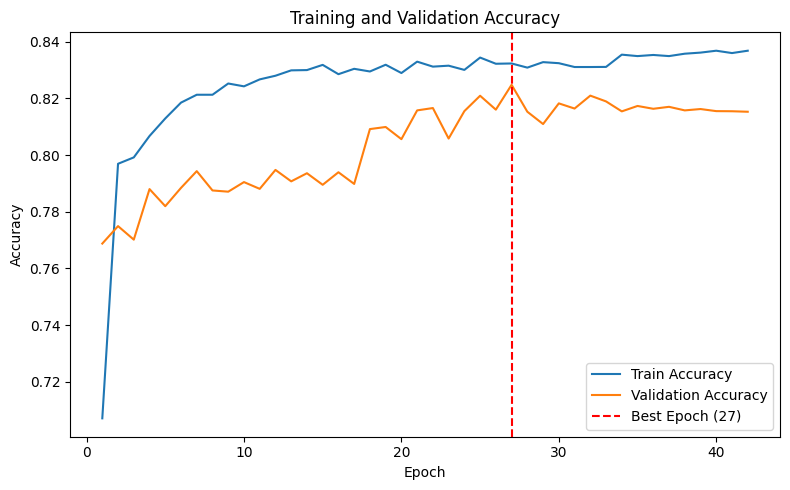

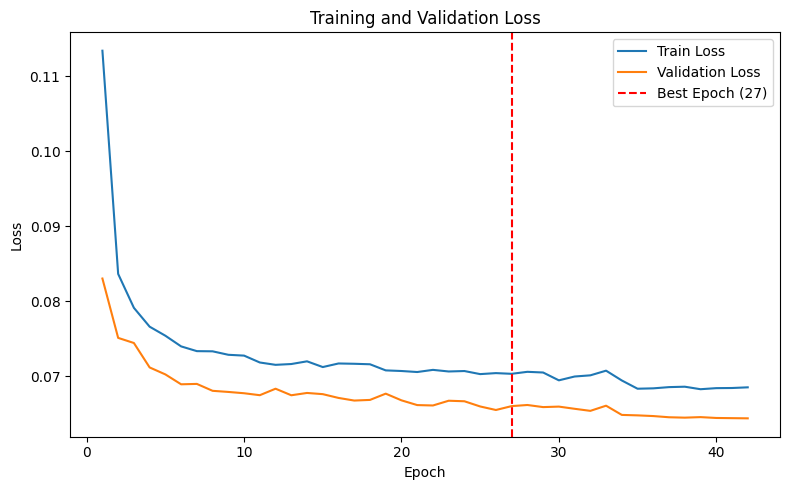

Plotted accuracy and loss curves. Best model selected at epoch 27.


In [10]:
# Save history and best epoch for best model
best_model_key = None
best_model_history = None

for key, history in history_dict.items():
    if history['val_acc'][-1] == best_val_acc:
        best_model_key = key
        best_model_history = history
        break

# Plot Accuracy Curve
if best_model_history:
    best_epoch = np.argmax(best_model_history['val_acc'])
    epochs_range = range(1, len(best_model_history['val_acc']) + 1)

    # Accuracy plot
    plt.figure(figsize=(8, 5))
    plt.plot(epochs_range, best_model_history['train_acc'], label='Train Accuracy')
    plt.plot(epochs_range, best_model_history['val_acc'], label='Validation Accuracy')
    plt.axvline(x=best_epoch + 1, color='red', linestyle='--', label=f"Best Epoch ({best_epoch + 1})")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{model_dir}/accuracy_curve_best_model.png")
    plt.show()

    # Loss plot
    plt.figure(figsize=(8, 5))
    plt.plot(epochs_range, best_model_history['train_loss'], label='Train Loss')
    plt.plot(epochs_range, best_model_history['val_loss'], label='Validation Loss')
    plt.axvline(x=best_epoch + 1, color='red', linestyle='--', label=f"Best Epoch ({best_epoch + 1})")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{model_dir}/loss_curve_best_model.png")
    plt.show()

    print(f"Plotted accuracy and loss curves. Best model selected at epoch {best_epoch + 1}.")


## Evaluate on Test Set

### Load best model

In [11]:
# After best model is saved, evaluate it on the test set
print("\n--- Evaluating Best Model on Test Set ---")
best_model.load_state_dict(torch.load(f"{model_dir}/best_mlp_model.pth"))
best_model.eval()


--- Evaluating Best Model on Test Set ---


MLP(
  (fc1): Linear(in_features=3, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (out): Linear(in_features=16, out_features=1, bias=True)
)

### Test best model

In [12]:
with torch.no_grad():
    y_test_pred_prob = best_model(X_test_tensor.to(device)).cpu().numpy().flatten()
    y_test_pred_label = (y_test_pred_prob >= 0.5).astype(int)

# Accuracy
test_acc = accuracy_score(y_test, y_test_pred_label)
print(f"Test Accuracy: {test_acc:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_label))

Test Accuracy: 0.8095

Classification Report:
              precision    recall  f1-score   support

         0.0       0.39      0.98      0.56      1436
         1.0       1.00      0.79      0.88     10094

    accuracy                           0.81     11530
   macro avg       0.69      0.88      0.72     11530
weighted avg       0.92      0.81      0.84     11530



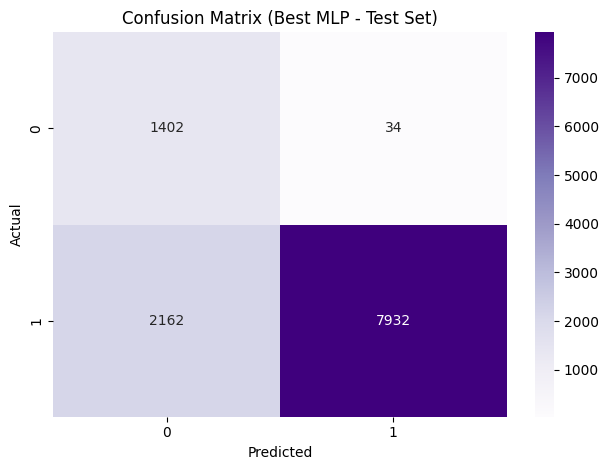

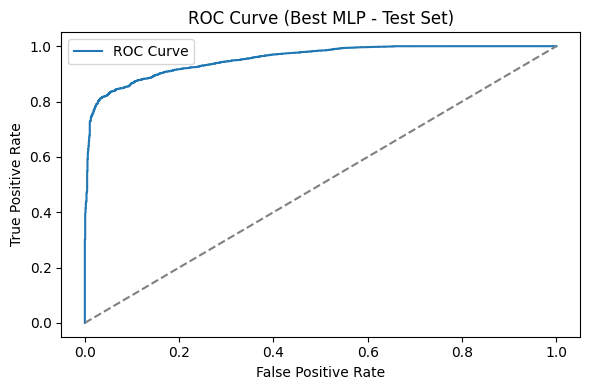

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_label)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix (Best MLP - Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(f"{model_dir}/confusion_matrix_best_mlp.png")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Best MLP - Test Set)")
plt.legend()
plt.tight_layout()
plt.savefig(f"{model_dir}/roc_curve_best_mlp.png")
plt.show()